In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [33]:
# Load the cleaned data
file_path = 'data/data_extended_clean.csv'
data = pd.read_csv(file_path)

layer_size = 32
batch_size = 16

model_name = f'ann_3-{layer_size}-1_batch{batch_size}'

train_model = False
save_model = False

In [34]:
# Normalizing the features
feature_scaler = StandardScaler()
features = data[['robot_speed', 'height_difference', 'width_difference']]
features = feature_scaler.fit_transform(features)
targets = data[['extrusion_speed']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=42)

# Model definition
model = Sequential()
model.add(Dense(layer_size, input_dim=X_train.shape[1], activation='elu'))
# model.add(Dense(layer_size, activation='elu'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/250


28/28 - 2s - loss: 109.2677 - val_loss: 108.4853 - 2s/epoch - 54ms/step
Epoch 2/250
28/28 - 0s - loss: 106.2940 - val_loss: 105.6455 - 328ms/epoch - 12ms/step
Epoch 3/250
28/28 - 0s - loss: 103.3805 - val_loss: 102.8056 - 312ms/epoch - 11ms/step
Epoch 4/250
28/28 - 0s - loss: 100.3765 - val_loss: 99.8987 - 337ms/epoch - 12ms/step
Epoch 5/250
28/28 - 0s - loss: 97.3269 - val_loss: 96.8154 - 351ms/epoch - 13ms/step
Epoch 6/250
28/28 - 0s - loss: 94.0812 - val_loss: 93.5237 - 345ms/epoch - 12ms/step
Epoch 7/250
28/28 - 0s - loss: 90.6139 - val_loss: 89.9998 - 329ms/epoch - 12ms/step
Epoch 8/250
28/28 - 0s - loss: 86.9044 - val_loss: 86.2522 - 346ms/epoch - 12ms/step
Epoch 9/250
28/28 - 0s - loss: 82.9808 - val_loss: 82.2802 - 334ms/epoch - 12ms/step
Epoch 10/250
28/28 - 0s - loss: 78.8616 - val_loss: 78.0263 - 327ms/epoch - 12ms/step
Epoch 11/250
28/28 - 0s - loss: 74.5276 - val_loss: 73.6949 - 331ms/epoch - 12ms/step
Epoch 12/250
28/28 - 0s - loss: 70.0292 - val_loss: 69.1278 - 308ms/epo

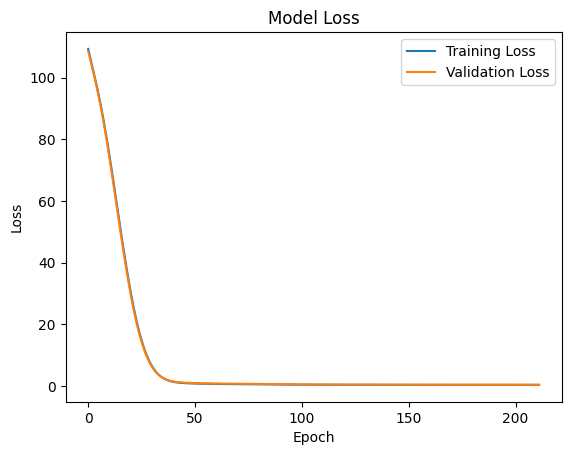

In [35]:


if train_model:
    # Train the model
    history = model.fit(X_train, y_train, epochs=250, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[early_stopping])
    


    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
else:
    from keras.saving import load_model
    model = load_model(f'model/{model_name}.keras')

In [36]:
if save_model and train_model:
    model.save(f'model/{model_name}.keras')
model.save(f'model/{model_name}.keras')

In [37]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 8ms/step - loss: 0.4591


0.4590623378753662

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

# Calculating MSE and MAE for Linear Regression Model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculating RMSE for both models
rmse = np.sqrt(mse)

# Printing the results
print("Test Split")
print("-----------")
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R^2:", r2)
print("-----------")

y_pred = model.predict(features)

mse = mean_squared_error(targets, y_pred)
mae = mean_absolute_error(targets, y_pred)
r2 = r2_score(targets, y_pred)
rmse = np.sqrt(mse)

print("Total")
print("-----------")
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R^2:", r2)
print("-----------")

6/6 [==============================] - 0s 5ms/step
Test Split
-----------
MSE: 0.4590622617546268
MAE: 0.5470329524389381
RMSE: 0.6775413358272887
R^2: 0.8833376834455268
-----------
23/23 [==============================] - 0s 5ms/step
Total
-----------
MSE: 0.3636567111896226
MAE: 0.4700792251388883
RMSE: 0.6030395602194126
R^2: 0.9006411183262928
-----------


In [39]:
robot_speed_test = np.arange(8,29)
layer_height_test = np.repeat(0, robot_speed_test.shape[0])
layer_width_test = np.repeat(0, robot_speed_test.shape[0])

test_data = pd.DataFrame({
    'robot_speed': robot_speed_test,
    'height_difference': layer_height_test,
    'width_difference': layer_width_test
})

In [40]:
save_test = True

test_scaled = feature_scaler.transform(test_data)

pred_extrusion_speed = model.predict(test_scaled)
test_data["do_prediction"] = np.round((pred_extrusion_speed-6)*10)
test_data["rpm_prediction"] = pred_extrusion_speed

if save_test:
    test_data.to_csv(f'validation_extended_{model_name}.csv', index=False)

test_data

1/1 [==============================] - 0s 63ms/step


,robot_speed,height_difference,width_difference,do_prediction,rpm_prediction
0,8,0,0,5.0,6.475409
1,9,0,0,9.0,6.923723
2,10,0,0,14.0,7.374066
3,11,0,0,18.0,7.824631
4,12,0,0,23.0,8.274994
5,13,0,0,27.0,8.719916
6,14,0,0,32.0,9.158383
7,15,0,0,36.0,9.591405
8,16,0,0,40.0,10.021651
9,17,0,0,44.0,10.449178
